In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import torch
from matplotlib.offsetbox import AnchoredText
from numpy.random import SeedSequence
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

from pyselect.datasets import make_gregorova_se1, make_gregorova_se2, make_jordan_se1
from pyselect.model import RFFNet

# Solvers

In [2]:
def prox_2_squared(x, alpha):
    "Proximal operator for l2 norm squared."
    return x / (1 + 2 * alpha)


def adam_palm(batch_size):
    torch.manual_seed(SEED)
    model = RFFNet(dims=[n_features, n_random_features, 1])

    optim_linear = torch.optim.Adam(model.linear.parameters(), lr=LR)
    optim_rff = torch.optim.Adam(model.rff.parameters(), lr=LR)

    no_improvement_count = 0
    best_val_loss = torch.Tensor([float("Inf")])

    history = []

    for epoch in range(N_EPOCHS):
        indices = torch.randperm(train_size)
        model.train()

        for i in range(train_size // batch_size):
            batch = indices[i * batch_size : (i + 1) * batch_size]
            pred = model(X_train[batch])

            loss = CRITERION(pred, y_train[batch])

            optim_linear.zero_grad()
            loss.backward()
            optim_linear.step()

            with torch.no_grad():
                curr_lr = optim_linear.param_groups[0]["lr"]
                model.linear.weight.data = prox_2_squared(
                    model.linear.weight.data, ALPHA * curr_lr
                )

        for i in range(train_size // batch_size):
            batch = indices[i * batch_size : (i + 1) * batch_size]
            pred = model(X_train[batch])

            loss = CRITERION(pred, y_train[batch])

            optim_rff.zero_grad()
            loss.backward()
            optim_rff.step()
            
        with torch.no_grad():
            val_loss = CRITERION(model(X_val), y_val)
            history.append(val_loss)

    return history

## Randomness

In [3]:
seed_sequence = SeedSequence(entropy=0)

In [4]:
SEED = seed_sequence.generate_state(1)[0]

## Data

In [5]:
n_samples = 6 * 10 ** 3
train_size = 5 * 10 ** 3

## Run

In [6]:
n_random_features = 200

In [7]:
N_EPOCHS = 100
LR = 1e-2
ALPHA = 1e-1
CRITERION = torch.nn.MSELoss()
MIN_DELTA_FRACTION=1.0
N_ITER_NO_CHANGE=10

In [8]:
jse1 = []
gse1 = []
gse2 = []

In [9]:
batch_sizes = np.arange(30, train_size//10, 70)

In [10]:
batch_sizes

array([ 30, 100, 170, 240, 310, 380, 450])

In [11]:
for loss, gen in zip([jse1, gse1, gse2] ,[make_jordan_se1, make_gregorova_se1, make_gregorova_se2]):
    X, y = gen(n_samples=n_samples, random_state=SEED)
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, train_size=train_size, random_state=SEED
    )
    n_features = X.shape[1]

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)

    X_train = torch.FloatTensor(X_train)
    X_val = torch.FloatTensor(X_val)
    y_train = torch.FloatTensor(y_train)
    y_val = torch.FloatTensor(y_val)
    
    for f in tqdm(batch_sizes):
        hist = adam_palm(f)
        loss.append(hist)
    
    

100%|██████████| 7/7 [01:08<00:00,  9.74s/it]


## Plot

In [12]:
CMAP = plt.cm.plasma
CMAP_R = plt.cm.plasma_r
COLORS = [CMAP(i / 3.0) for i in range(4)]

In [13]:
COLOR_0 = COLORS[0]
COLOR_1 = COLORS[1]
COLOR_2 = COLORS[2]

In [14]:
TEXTWIDTH = 3.25063
FONTSIZE = 6

In [15]:
def setup():
    matplotlib.rcParams.update({"font.size": FONTSIZE})  # controls default text sizes
    matplotlib.rcParams.update({"axes.titlesize": FONTSIZE})  # fontsize of the axes title
    matplotlib.rcParams.update({"axes.labelsize": FONTSIZE})  # fontsize of the x and y labels
    matplotlib.rcParams.update({"axes.formatter.use_mathtext": True})  # use scientific notation for axes with pretty formatting
    matplotlib.rcParams.update({"axes.formatter.useoffset": True}) #
    matplotlib.rcParams.update({"axes.formatter.limits": [0, 0]})  
    matplotlib.rcParams.update({"xtick.labelsize": FONTSIZE})  # fontsize of the tick labels
    matplotlib.rcParams.update({"ytick.labelsize": FONTSIZE})  # fontsize of the tick labels
    matplotlib.rcParams.update({"legend.fontsize": FONTSIZE})  # legend fontsize
    matplotlib.rcParams.update({"figure.titlesize": FONTSIZE})  # fontsize of the figure title
    matplotlib.rcParams.update({"figure.dpi": 300})
    matplotlib.rcParams.update({"savefig.dpi": 300})

In [21]:
setup()

In [22]:
import matplotlib.ticker as mticker

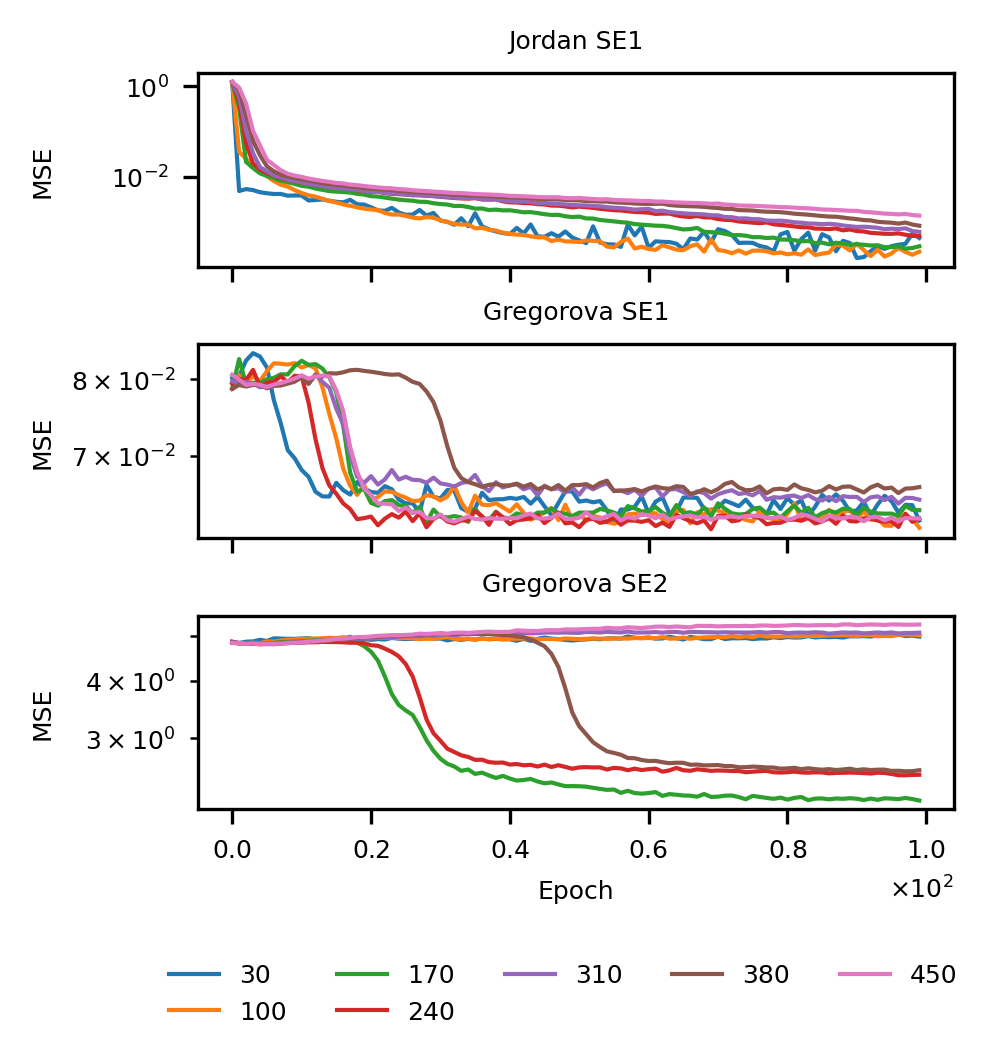

In [24]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(TEXTWIDTH, TEXTWIDTH))
fig.subplots_adjust(hspace=0.4, wspace=0.2)

formatter = mticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1)) 

for i in range(len(batch_sizes)):
    ax1.plot(jse1[i], '-', lw=1, ms=2, label="%d"%batch_sizes[i])
ax1.set_title("Jordan SE1")
ax1.set_ylabel("MSE")
ax1.set_yscale('log')

for i in range(len(batch_sizes)):
    ax2.plot(gse1[i], '-', lw=1, ms=2, label="%d"%batch_sizes[i])
ax2.set_title("Gregorova SE1")
ax2.set_ylabel("MSE")
ax2.set_yscale('log')

for i in range(len(batch_sizes)):
    ax3.plot(gse2[i], '-', lw=1, ms=2, label="%d"%batch_sizes[i])
ax3.set_title("Gregorova SE2")
ax3.set_ylabel("MSE")
ax3.set_yscale('log')
ax3.set_xlabel("Epoch")

fig.align_ylabels()

lines_labels = [ax1.get_legend_handles_labels()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc=9, bbox_to_anchor=(0.5, -0.01), ncols=5, frameon=False)

plt.savefig("../figures/validation/batch_sizes.pdf", bbox_inches="tight")

plt.show()